In [1]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

ModuleNotFoundError: No module named 'yfinance'

In [ ]:
tickers = ['APPL','GOOGL','AMZN','MSFT','TSLA']
start_date = '2019-01-01'
end_date = '2025-05-25'
data = {ticker: yf.download(ticker, start=start_date, end=end_date) for ticker in tickers}


📊 Processing AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

📈 Predicted Prices for the next 10 days:
            Predicted Price
Date                       
2025-05-12       216.745849
2025-05-13       217.994527
2025-05-14       217.644435
2025-05-15       217.130957
2025-05-16       217.020092
2025-05-19       215.573028
2025-05-20       214.452720
2025-05-21       211.669449
2025-05-22       211.243500
2025-05-23       207.690021


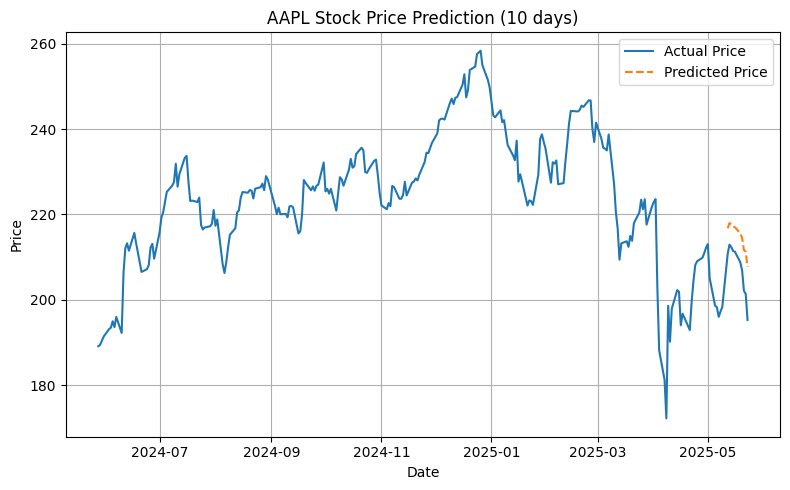


📊 Processing MSFT...


[*********************100%***********************]  1 of 1 completed

📈 Predicted Prices for the next 10 days:
            Predicted Price
Date                       
2025-05-12       436.201765
2025-05-13       436.133630
2025-05-14       438.291722
2025-05-15       438.872080
2025-05-16       439.520694
2025-05-19       442.137946
2025-05-20       441.739680
2025-05-21       438.553460
2025-05-22       439.856382
2025-05-23       437.193620


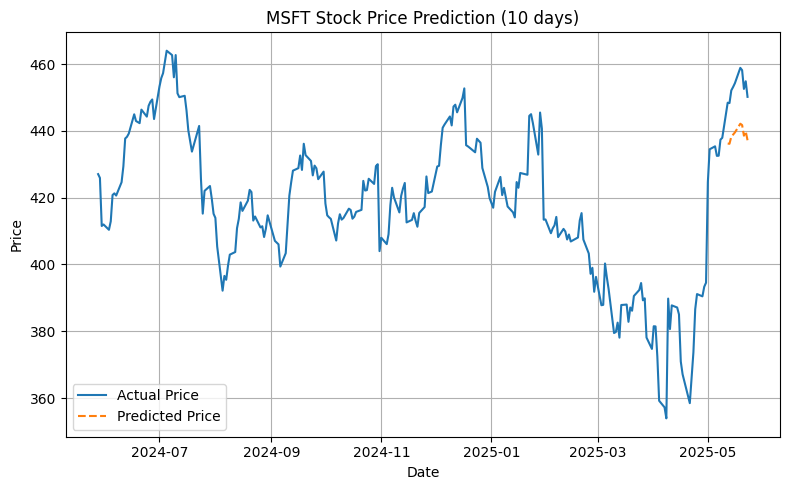


📊 Processing GOOGL...


[*********************100%***********************]  1 of 1 completed

📈 Predicted Prices for the next 10 days:
            Predicted Price
Date                       
2025-05-12       161.717593
2025-05-13       162.506665
2025-05-14       166.813404
2025-05-15       165.773600
2025-05-16       167.418123
2025-05-19       167.676226
2025-05-20       165.788341
2025-05-21       169.165889
2025-05-22       170.869410
2025-05-23       169.099521


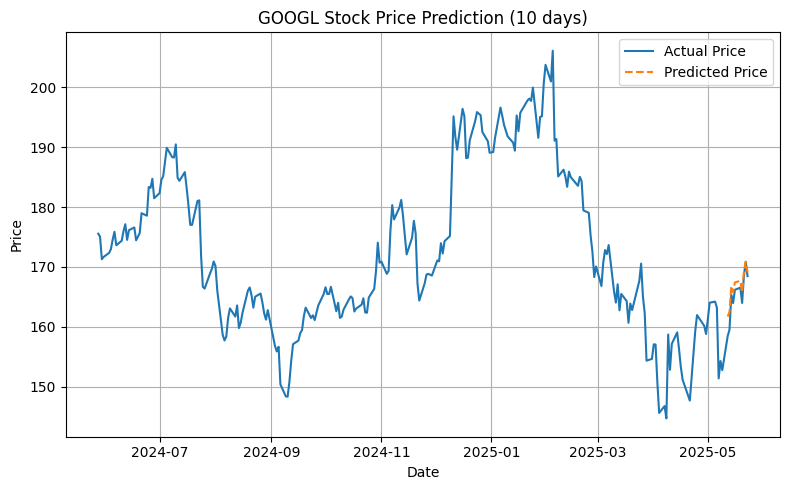


📊 Processing AMZN...


[*********************100%***********************]  1 of 1 completed

📈 Predicted Prices for the next 10 days:
            Predicted Price
Date                       
2025-05-12       207.103552
2025-05-13       209.215554
2025-05-14       208.349094
2025-05-15       204.419060
2025-05-16       204.743983
2025-05-19       205.184957
2025-05-20       203.568076
2025-05-21       201.285862
2025-05-22       202.817655
2025-05-23       201.185299


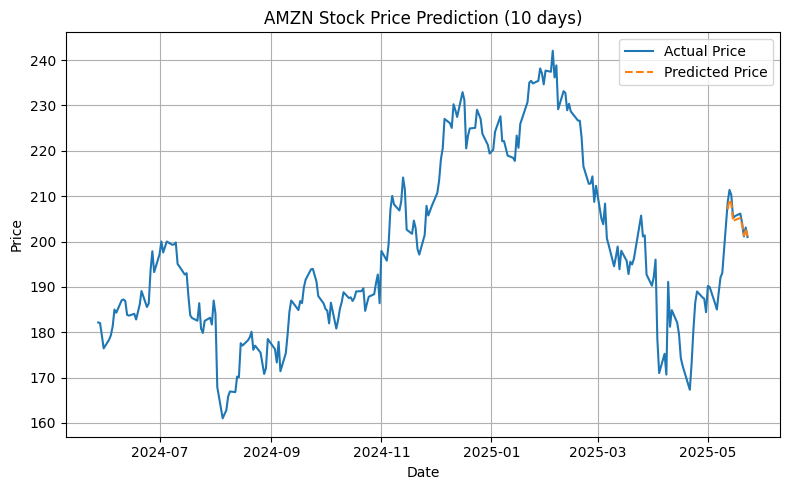


📊 Processing TSLA...


[*********************100%***********************]  1 of 1 completed

📈 Predicted Prices for the next 10 days:
            Predicted Price
Date                       
2025-05-12       318.132472
2025-05-13       330.991726
2025-05-14       342.146233
2025-05-15       338.163074
2025-05-16       344.031288
2025-05-19       337.564769
2025-05-20       338.982656
2025-05-21       331.442486
2025-05-22       336.704218
2025-05-23       335.310917


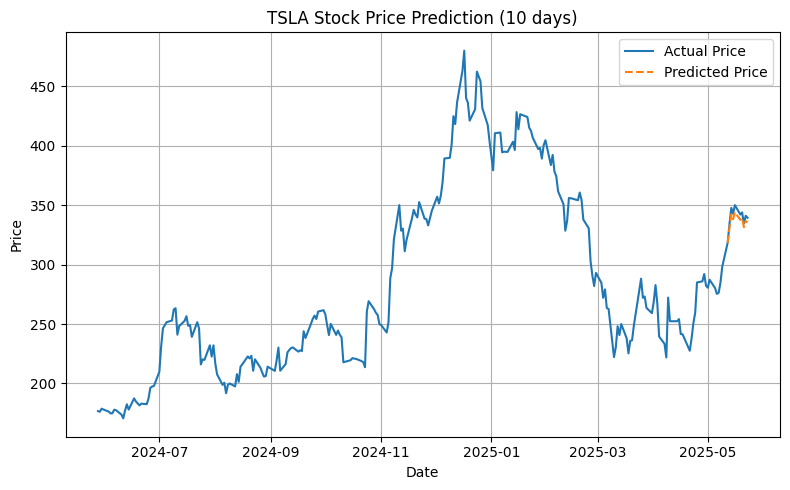

In [1]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# List of stocks to predict
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Data range to use in the model
end_date = datetime.today()
start_date = end_date - timedelta(days=365)  # Use 1 year of data

forecast_days = 10  # Predict 10 days ahead

# Downloading and processing data
for ticker in stocks:
    print(f"\n📊 Processing {ticker}...")

    try:
        # Download stock data
        df = yf.download(ticker, start=start_date, end=end_date)
        df = df[['Close']]
        df.dropna(inplace=True)

        # Prepare data
        df['Prediction'] = df['Close'].shift(-forecast_days)
        X = df[['Close']][:-forecast_days]
        y = df['Prediction'][:-forecast_days]

        # Train model
        model = LinearRegression()
        model.fit(X, y)

        # Predict
        x_future = df[['Close']][-forecast_days:]
        forecast = model.predict(x_future)

        # Show predicted prices
        prediction_dates = df.index[-forecast_days:]
        forecast_df = pd.DataFrame({'Date': prediction_dates, 'Predicted Price': forecast})
        forecast_df.set_index('Date', inplace=True)

        print("📈 Predicted Prices for the next", forecast_days, "days:")
        print(forecast_df)

        # Plot results
        plt.figure(figsize=(8, 5))
        plt.title(f'{ticker} Stock Price Prediction ({forecast_days} days)')
        plt.plot(df['Close'], label='Actual Price')
        plt.plot(forecast_df['Predicted Price'], label='Predicted Price', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error processing {ticker}: {e}")
